In [1]:
%load_ext autoreload
%autoreload 2

import warnings

import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
import seaborn as sns

from matplotlib.gridspec import GridSpec
from esda.moran import Moran
from cartopy import crs as ccrs

from math import ceil
import random
import textwrap

from matplotlib.ticker import AutoMinorLocator
from matplotlib.colors import LinearSegmentedColormap
from pysal.lib import weights

import matplotlib.font_manager as fm

import src.cluster_anlaysis as ca
import src.compile_fns as cf

warnings.filterwarnings("ignore")

# Configure Seaborn styles
sns.set_style("whitegrid", {'grid.linestyle': 'dotted'})
sns.set_context("notebook", font_scale=1.2, rc={"lines.linewidth": 2.5})

# Define default color palettes
colors_list = [
    "#FF0000", "#FF4500", "#FFA500", "#FFD700", "#FFFF00",
    "#ADFF2F", "#32CD32", "#008000"
]
default_cmap = mcolors.LinearSegmentedColormap.from_list("bright_RdGnYl", colors_list)
colors = sns.color_palette("RdYlGn", 5)

# Set custom font
def set_custom_font(font_path):
    try:
        fm.fontManager.addfont(font_path)
        plt.rcParams['font.family'] = 'sans-serif'
        plt.rcParams['font.sans-serif'] = ['Lato']
    except FileNotFoundError:
        print(f"Font file not found at: {font_path}. Using default font.")

font_path = 'data/utils/fonts/Lato-Regular.ttf'
set_custom_font(font_path)

In [2]:
india_boundary = gpd.read_file('data/admin_boundaries/district_boundaries_shp/output.shp')
india_intl = gpd.read_file('data/admin_boundaries/india_intl/india_intl.shp')

from shapely.ops import unary_union
def create_efficient_boundary(gdf):
    dissolved = gdf.dissolve()
    boundary = unary_union(dissolved.geometry)
    boundary_gdf = gpd.GeoDataFrame(geometry=[boundary], crs=gdf.crs)
    return boundary_gdf

boundary = create_efficient_boundary(india_boundary)
boundary_diff = gpd.overlay(boundary, india_intl, how='difference')

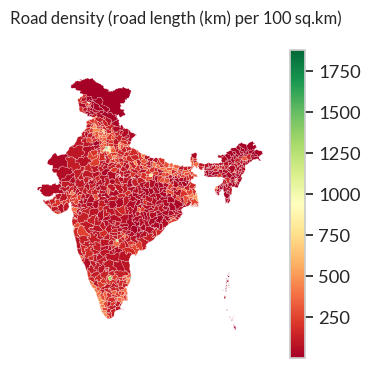

In [4]:
data_gdf = gpd.read_parquet("data/resilience_data.parquet")
ci_gdf = gpd.read_parquet("data/resilience_indicators.parquet")

fig, ax = plt.subplots(1, 1, figsize=(4,4))
data_gdf.plot(ax=ax, column = "roads_100sqkm", edgecolor='white', linewidth=0.1,
              cmap='RdYlGn', legend=True)
plt.suptitle("Road density (road length (km) per 100 sq.km)", fontsize=12)
ax.set_axis_off()

In [5]:
# Assuming cf is imported elsewhere
indicators_dict = cf.indicators_dict
indicators_key_dict = cf.indicators_key_dict
indicator_vars = []
indicator_names = []
hazard_vars = []
var_breaks = [0]

for pillar in indicators_dict.keys():
    if pillar != 'hazard':
        var_breaks.append(var_breaks[-1] + len(indicators_dict[pillar].keys()))
        for key, field in indicators_dict[pillar].items():
            indicator_vars.append(field[0])
            indicator_names.append(key)
    else:
        for key, field in indicators_dict[pillar].items():
            hazard_vars.append(field[0])


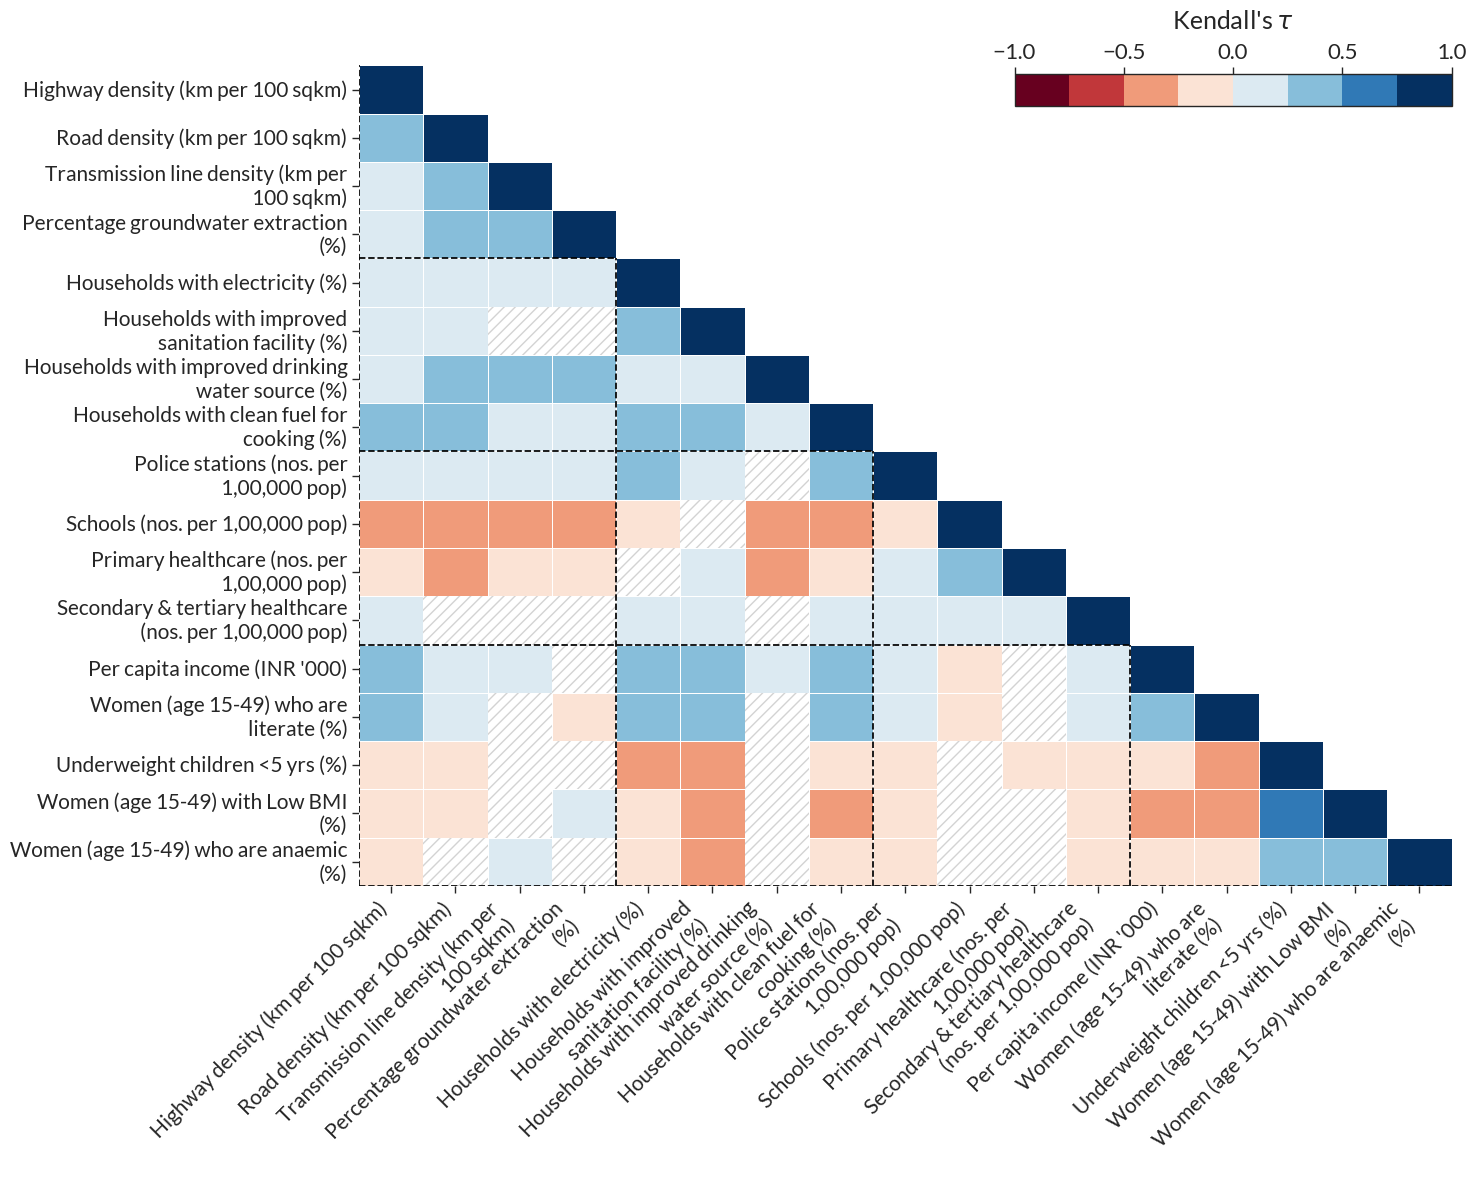

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
from scipy.stats import kendalltau
from mpl_toolkits.axes_grid1 import make_axes_locatable
import textwrap  # Import textwrap module

# Initialize matrices for Kendall's tau and p-values
n = len(indicator_vars)
tau_matrix = np.zeros((n, n))
pval_matrix = np.zeros((n, n))

# Compute Kendall's tau and p-values
for i in range(n):
    for j in range(n):
        if i != j:
            tau, p = kendalltau(data_gdf[indicator_vars[i]], data_gdf[indicator_vars[j]])
            tau_matrix[i, j] = tau
            pval_matrix[i, j] = p
        else:
            tau_matrix[i, j] = 1  # Diagonal
            pval_matrix[i, j] = np.nan  # Not applicable

# Create a mask for the upper triangle only
mask = np.triu(np.ones_like(tau_matrix, dtype=bool), k=1)

# Create a custom matrix for the background color, only showing significant values
color_matrix = tau_matrix.copy()
color_matrix[pval_matrix > 0.05] = np.nan  # Remove background color for non-significant values

# Plot the heatmap
sns.set_context('paper', font_scale=1.5)
sns.set_style('white')
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Lato']

f, ax = plt.subplots(figsize=(15, 12))
cmap = cm.get_cmap("RdBu", 8)

# Plot the heatmap with colors only for significant values
im = sns.heatmap(
    color_matrix, mask=mask, cmap=cmap, vmax=1, center=0,
    square=False, linewidths=.5, vmin=-1,
    fmt='.2f', annot_kws={"size": 12},
    cbar=False  # Disable the default colorbar
)

# Overlay hatch patterns for non-significant values (p > 0.05)
for i in range(n):
    for j in range(n):
        if not mask[i, j] and pval_matrix[i, j] > 0.05:  # If not masked and p > 0.05
            ax.add_patch(plt.Rectangle((j, i), 1, 1, fill=False, hatch='///', edgecolor='lightgray', lw=0))

# Function to wrap text labels
def wrap_labels(labels, max_length=33):
    return [textwrap.fill(label, max_length) for label in labels]

# Apply text wrapping to axis labels
wrapped_labels = wrap_labels(indicator_names)
# wrapped_labels = [label.split("(")[0] for label in wrapped_labels]
ax.set_xticklabels(wrapped_labels, rotation=45, ha='right', size=15)
ax.set_yticklabels(wrapped_labels, rotation=0, va='center', size=15)

# Add vertical lines
for i in var_breaks:
    ax.axvline(i, ymin=0, ymax=1 - i/var_breaks[-1], color='black', linestyle='--', linewidth=1.25)

# Add horizontal lines
for i in var_breaks:
    ax.axhline(i, xmin=0, xmax=i/var_breaks[-1], color='black', linestyle='--', linewidth=1.25)

#axis ticks visible
ax.tick_params(axis='both', which='both', bottom=True, top=False, left=True, right=False)

# Create colorbar
divider = make_axes_locatable(ax)
cax = ax.inset_axes([0.6, 0.95, 0.4, 0.04])
cbar = plt.colorbar(im.get_children()[0], cax=cax, orientation="horizontal", 
                   ticks=[-1, -0.5, 0, 0.5, 1], fraction=0.05)
cbar.set_label("Kendall's $\\tau$ ", fontsize=18, labelpad=10)
cbar.ax.xaxis.set_label_position('top')
cbar.ax.tick_params(labelsize=16)
#make ticks visible
cbar.ax.xaxis.set_ticks_position('top')

# Adjust layout to accommodate wrapped text
plt.tight_layout()


# plt.savefig("graphics/indicators_corr.pdf", dpi=300, bbox_inches='tight')
plt.savefig("graphics/indicators_corr.png", dpi=600, bbox_inches='tight')
plt.show()


In [7]:
# RUN THIS CELL TO LOAD THE DATA
FONT_FAMILY = 'sans-serif'
FONT_NAME = 'Lato'
PLOT_FONT_SIZE = 13
ANNOTATION_FONT_SIZE = 11
TITLE_WIDTH = 30
COLORBAR_FRAME_LINEWIDTH = 0.2
COLORBAR_FRAME_COLOR = 'lightgrey'
DEFAULT_CMAP = default_cmap

# Configure Fonts and Styles
plt.rcParams['font.family'] = FONT_FAMILY
plt.rcParams['font.sans-serif'] = [FONT_NAME]

# Utility Functions
def calculate_statistics(column_values, weight_matrix):
    """Calculate Moran's I and related statistics."""
    feature_mean = column_values.mean()
    feature_std = column_values.std()
    moran = Moran(column_values, weight_matrix)
    return feature_mean, feature_std, moran.I, moran.p_norm


def add_annotations(ax, feature_mean, feature_std, moran_i, moran_p):
    """Add statistical annotations to the plot."""
    annotation = (
        f"$\\mu$ = {feature_mean:.2f}\n"
        f"$\\sigma$ = {feature_std:.2f}\n"
        f"I = {moran_i:.2f}" + ("*" if moran_p < 0.05 else "")
    )
    ax.text(
        0.9, 0.15, annotation,
        transform=ax.transAxes, ha="right", va="bottom",
        fontsize=ANNOTATION_FONT_SIZE,
        bbox=dict(facecolor='white', alpha=0.8, edgecolor='none')
    )


def plot_field(data_gdf, data_gdf_moran, field, field_info, dax, weight_matrix):
    """Plot individual fields with associated annotations."""
    column = field_info[0]
    cmap = DEFAULT_CMAP if field_info[3] == 'R' else DEFAULT_CMAP.reversed()

    # Plot the map
    im = data_gdf.plot(
        column=column, cmap=cmap, ax=dax,
        edgecolor=None, legend=True, alpha=1,
        legend_kwds={
            'orientation': "horizontal", 'location': "bottom",
            'shrink': 0.9, 'aspect': 17, 'pad': 0
        },
        missing_kwds={'color': 'whitesmoke', 'edgecolor': 'grey', 'alpha': 0.3},
        linewidth=0.05
    )

    # Configure colorbar
    colorbar = im.get_figure().get_axes()[-1]
    colorbar.tick_params(labelsize=ANNOTATION_FONT_SIZE)
    [spine.set_linewidth(COLORBAR_FRAME_LINEWIDTH) for spine in colorbar.spines.values()]
    [spine.set_edgecolor(COLORBAR_FRAME_COLOR) for spine in colorbar.spines.values()]

    # Gridlines
    dax.gridlines(draw_labels=False, crs=ccrs.PlateCarree(),
                  linestyle='dotted', color='black', linewidth=0.5, alpha=0.1)

    # Calculate and annotate statistics
    column_values = data_gdf_moran[column]
    feature_mean, feature_std, moran_i, moran_p = calculate_statistics(column_values, weight_matrix)
    add_annotations(dax, feature_mean, feature_std, moran_i, moran_p)

    return im

# prefix_dict = {
#     'hazard': 'a', 'community': 'c', 'infrastructure_accessibility': 'd',
#     'social_infrastructure': 'b', 'critical_infrastructure': 'a', 'state_capacity': 'e'
# }
prefix_dict = {
    'critical_infrastructure': 'a',
    'infrastructure_accessibility': 'b',
    'social_infrastructure': 'c',
    'community': 'd'
}

# Main Plotting Code
def main_plot(data_gdf, data_gdf_moran, weight_matrix, list_to_plot, plot_num):
    
    total_rows = sum(ceil(len(cf.indicators_dict[pillar].keys()) / max_cols) for pillar in list_to_plot)
    fig = plt.figure(figsize=(2.6 * max_cols, 3.6 * total_rows))
    gridspec = GridSpec(total_rows, max_cols, figure=fig)

    current_row = 0

    for indicator_index, key in enumerate(list_to_plot):
        field_dict = cf.indicators_dict[key]
        nrows = ceil(len(field_dict) / max_cols)

        # Add vertical category label
        prefix = prefix_dict[key]
        category_text = f"{prefix}. {key.replace('_', ' ').title()}"
        fig.text(
            -0.012, 1 - ((current_row + 1 / 2) / total_rows), category_text,
            ha="left", va="center", fontsize=14, rotation=90
        )

        # Plot each field
        for index, (feature, field_info) in enumerate(field_dict.items()):
            row, col = current_row + (index // max_cols), index % max_cols
            dax = fig.add_subplot(gridspec[row, col], projection=ccrs.PlateCarree())

            # Plot and configure the field
            plot_field(data_gdf, data_gdf_moran, feature, field_info, dax, weight_matrix)

            # Set title
            title = f"({roman_numerals[index]}) {feature}"
            dax.set_title("\n".join(textwrap.wrap(title, width=TITLE_WIDTH)), fontsize=PLOT_FONT_SIZE)
            dax.axis('off')

            # Add boundary layers
            outer_boundary.plot(ax=dax, color='black', linewidth=0.1)
            boundary_diff.plot(ax=dax, color='white', linewidth=0.1, edgecolor='black',
                               linestyle='--', alpha=0.8)

        current_row += nrows

    # Turn off unused gridspec positions
    for idx in range(total_rows * max_cols):
        if idx >= len(list_to_plot):
            fig.add_subplot(gridspec[idx // max_cols, idx % max_cols]).axis('off')

    plt.tight_layout()
    plt.show()

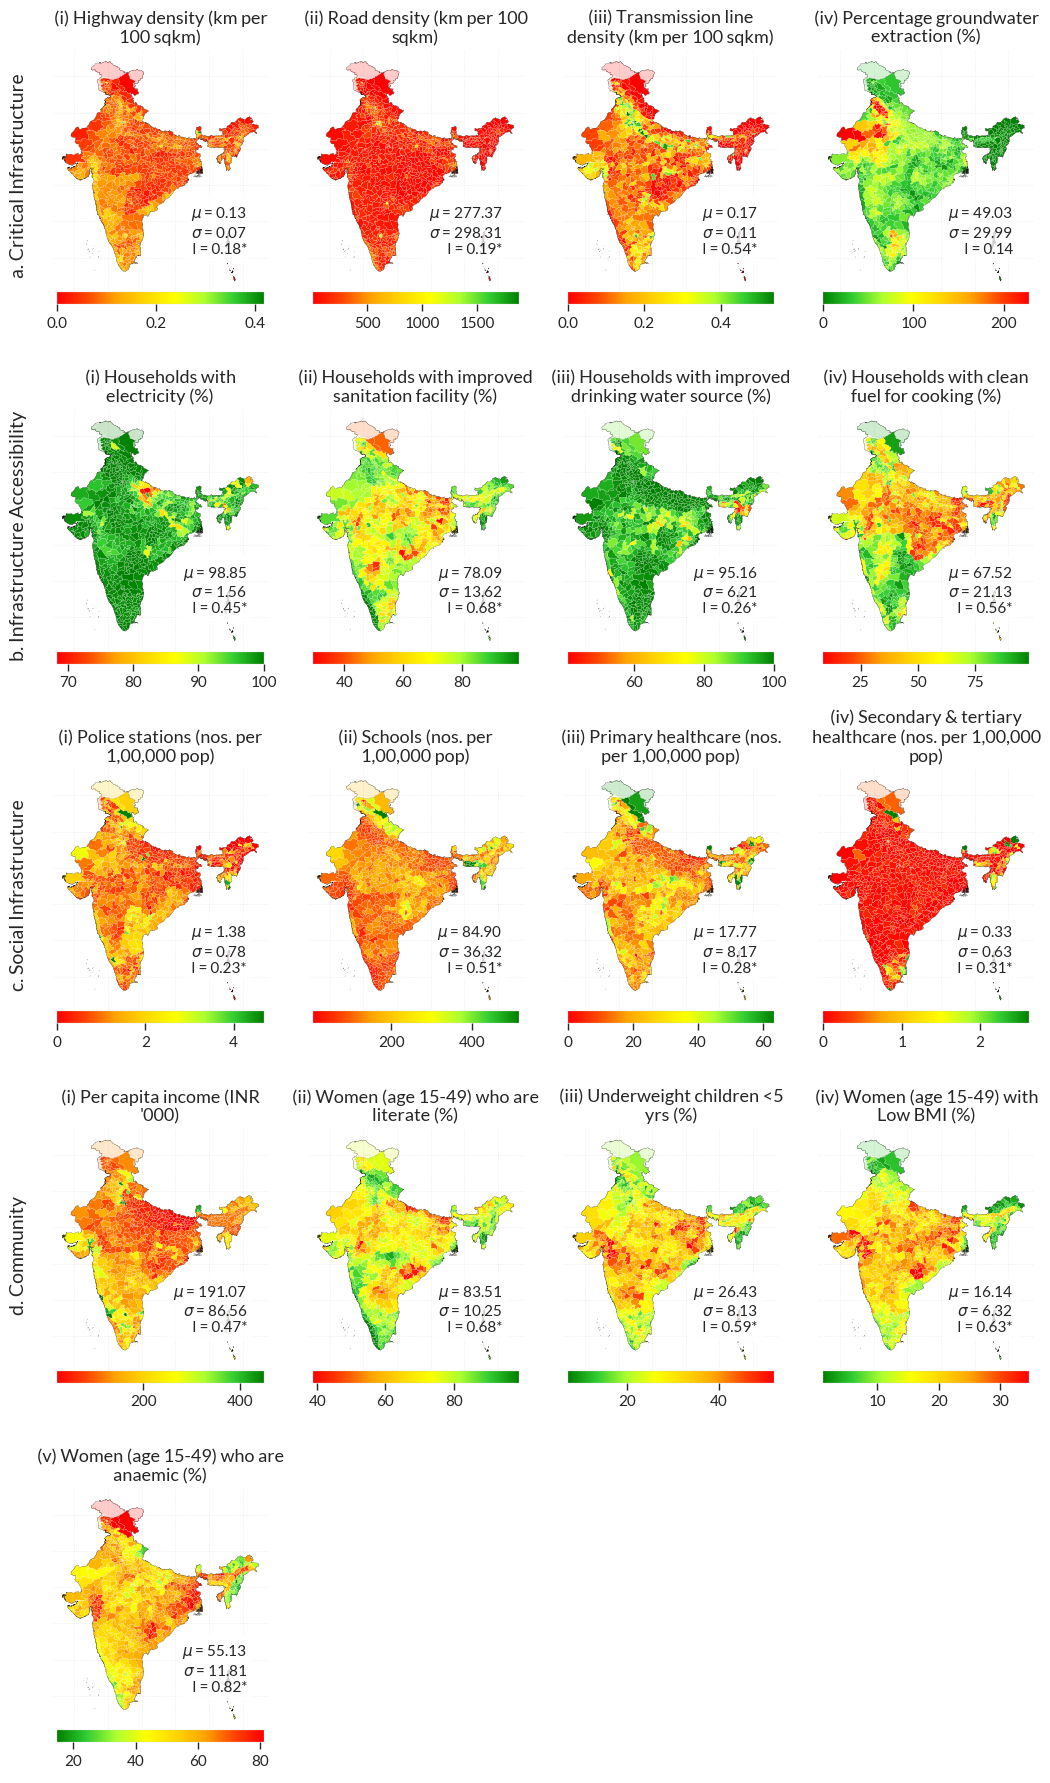

In [8]:

outer_boundary = boundary.boundary
data_gdf = data_gdf.to_crs(epsg=outer_boundary.crs.to_epsg())

# Call the Main Plot Function
list_to_plot, plot_num = ['critical_infrastructure', 'infrastructure_accessibility', 
'social_infrastructure', "community"], 1
# list_to_plot, plot_num = ['infrastructure_accessibility','state_capacity'], 2
# list_to_plot, plot_num = ['hazard'], 3
max_cols = 4

indicator_vars = [values[0] for pillar in cf.indicators_dict.keys() for values in cf.indicators_dict[pillar].values()]

disconnected_ids = [0, 1, 2, 316]
data_gdf_moran = data_gdf[~data_gdf.index.isin(disconnected_ids)].dropna(subset=indicator_vars)
w = weights.Queen.from_dataframe(data_gdf_moran[indicator_vars + ['geometry']], use_index=False)

# Define Roman Numerals for Prefix
roman_numerals = ['i', 'ii', 'iii', 'iv', 'v', 'vi', 'vii', 'viii', 'ix', 'x']

main_plot(data_gdf, data_gdf_moran, w, list_to_plot, plot_num)


## Composite Infrastructure and Community Indicators

In [9]:
indicators_dict = cf.indicators_dict

data_resilience_gdf = data_gdf.copy()
for cluster_type in indicators_dict.keys():
    print("**************************************")
    print (f"Processing cluster type: {cluster_type}")
    print("**************************************")
    
    for key, values in indicators_dict[cluster_type].items():
        print(key, values)

        if cluster_type == "community":
            if values[3] == 'R':
                data_resilience_gdf[values[0]] = -data_resilience_gdf[values[0]]
        else:
            if values[3] == 'V':
                data_resilience_gdf[values[0]] = -data_resilience_gdf[values[0]]

**************************************
Processing cluster type: hazard
**************************************
Severe cyclones ['severe_cyclones', 0, -1, 'H']
Wind speed (knots) ['wind_speed_knots', 0, -1, 'H']
Maximum storm surge (m) ['pmss_m', 0, -1, 'H']
Maximum precipitation (cm) ['pmp_cm', 0, -1, 'H']
**************************************
Processing cluster type: critical_infrastructure
**************************************
Highway density (km per 100 sqkm) ['highway_per_100sqkm', 0, -1, 'R']
Road density (km per 100 sqkm) ['roads_100sqkm', 0, -1, 'R']
Transmission line density (km per 100 sqkm) ['transmission_100sqkm', 0, -1, 'R']
Percentage groundwater extraction (%) ['perc_extraction', 0, -1, 'V']
**************************************
Processing cluster type: infrastructure_accessibility
**************************************
Households with electricity (%) ['perc_hh_electricity', 0, 100, 'R']
Households with improved sanitation facility (%) ['perc_hh_sanitation', 0, 100, 'R'

In [10]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import RobustScaler, StandardScaler

def find_optimal_components(data, variance_threshold=0.95):
    # Standardize the data
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(data)
    pca = PCA()
    pca.fit(data_scaled)
    cumulative_variance_ratio = np.cumsum(pca.explained_variance_ratio_)
    n_components = np.argmax(cumulative_variance_ratio >= variance_threshold) + 1
    return n_components

indicators_dict_new = {}
for cluster_type in indicators_dict.keys():
    indicators_dict_new[cluster_type] = {values[0]: key for key, values in indicators_dict[cluster_type].items()}

for cluster_type in indicators_dict.keys():
    #print(f"Calculating composite index for {cluster_type}")
    columns = [values[0] for values in indicators_dict[cluster_type].values()]
    dat = data_resilience_gdf[columns].copy()
    dat.replace(np.nan,0,inplace=True)

    # Perform robust scaling
    scaler = StandardScaler()
    dat_scaled = scaler.fit_transform(dat)

    n_compon = find_optimal_components(dat_scaled)

    # Perform PCA
    pca = PCA(n_components=n_compon)
    pca_components = pca.fit_transform(dat_scaled)
    explained_variance = pca.explained_variance_ratio_

    # weights = np.abs(pca.components_[0])
    # weights = weights / weights.sum()
    components = np.abs(pca.components_)
    variable_contributions = np.zeros(components.shape[1])  # One weight per variable
    for k in range(n_compon):
        variable_contributions += components[k, :] * explained_variance[k]

    # Normalize contributions to sum to 1
    weights = variable_contributions / variable_contributions.sum()
    # Create a dictionary of variable weights
    variable_weights = dict(zip(columns, weights))

    # Calculate the composite index
    composite_index = np.zeros(len(dat))
    for var, weight in variable_weights.items():
        print(indicators_dict_new[cluster_type][var], "@", weight)
        # Add weighted standardized values
        composite_index += weight * dat_scaled[:, columns.index(var)]

    # Scale the index to 0-100 range for easier interpretation
    min_val = composite_index.min()
    max_val = composite_index.max()
    data_resilience_gdf[f'CI_{cluster_type}'] = composite_index #100 * (composite_index - min_val) / (max_val - min_val)

    # dat['geometry'] = data_resilience_gdf['geometry']
    # dat = gpd.GeoDataFrame(dat, crs=data_resilience_gdf.crs)


Severe cyclones @ 0.2450670843666522
Wind speed (knots) @ 0.24185980696747358
Maximum storm surge (m) @ 0.2560322075775434
Maximum precipitation (cm) @ 0.2570409010883308
Highway density (km per 100 sqkm) @ 0.2577095378501555
Road density (km per 100 sqkm) @ 0.2409452021904475
Transmission line density (km per 100 sqkm) @ 0.2542693124756762
Percentage groundwater extraction (%) @ 0.24707594748372086
Households with electricity (%) @ 0.2609001329751372
Households with improved sanitation facility (%) @ 0.27677723703255597
Households with improved drinking water source (%) @ 0.22965775310421305
Households with clean fuel for cooking (%) @ 0.2326648768880938
Police stations (nos. per 1,00,000 pop) @ 0.23643338603979597
Schools (nos. per 1,00,000 pop) @ 0.26852028173505726
Primary healthcare (nos. per 1,00,000 pop) @ 0.23970924149668169
Secondary & tertiary healthcare (nos. per 1,00,000 pop) @ 0.25533709072846517
Per capita income (INR '000) @ 0.20560118067320304
Women (age 15-49) who are 

In [ ]:
# cols = ["district", "state", "distid", "geometry"] + [f'CI_{cluster_type}' for cluster_type in indicators_dict.keys()]
# data_resilience_gdf[cols].to_parquet("data/resilience_indicators.parquet", index=False)

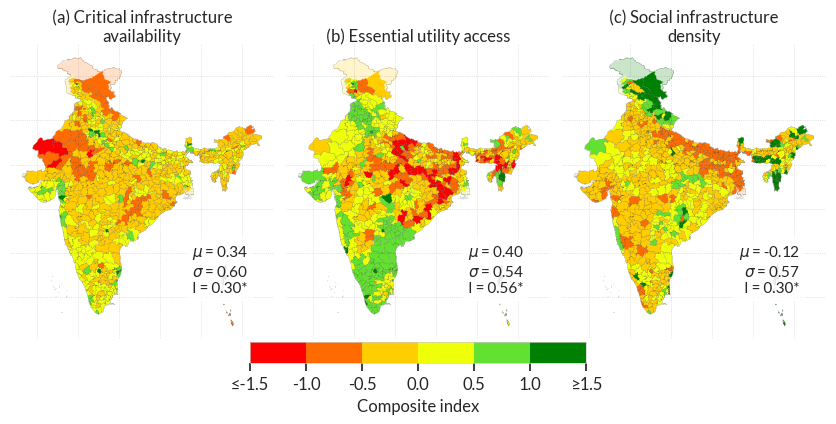

In [19]:
import math 
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np
import textwrap
from pypalettes import load_cmap
cmap = load_cmap("Huida")
import cartopy.crs as ccrs
from pysal.lib import weights

lower_bound = -1.5
upper_bound = 1.5
interval = 0.5

# indicators_dict = cf.indicators_dict
# cluster_types = [cluster_type for cluster_type in indicators_dict.keys() if cluster_type != 'hazard']

def create_custom_cmap(cmap_name):
    bounds = np.arange(lower_bound, upper_bound + interval, interval).tolist()
    cmap = default_cmap #plt.get_cmap("RdYlGn")#mcolors.LinearSegmentedColormap.from_list(cmap_name, colors_list)
    norm = colors.BoundaryNorm(bounds, cmap.N)
    return cmap, norm

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Lato']

cmap_r, norm = create_custom_cmap(cmap_name = default_cmap)

indicator_text = {
    # 'hazard': 'Hazard',
    'critical_infrastructure': 'Critical infrastructure availability',
    'infrastructure_accessibility': 'Essential utility access',
    'social_infrastructure': 'Social infrastructure density',
    'community': 'Community vulnerability',
    # 'state_capacity_social': 'State capacity (social)',
    # 'state_capacity_economic': 'State capacity (economic)',
    # 'state_capacity': 'State capacity'
}

total_figs = len(list(indicator_text.keys())[0:3])
ncols = 3
nrows = math.ceil(total_figs / ncols)

fig, axes = plt.subplots(nrows, ncols, figsize=(2.8*ncols, 3.5*nrows), subplot_kw={'projection': ccrs.PlateCarree()})
axes = axes.flatten()

# Initialize Weight Matrix (same as before but for resilience data)
disconnected_ids = [0, 1, 2, 316]
data_resilience_moran = data_resilience_gdf[~data_resilience_gdf.index.isin(disconnected_ids)].dropna()
w_resilience = weights.Queen.from_dataframe(data_resilience_moran[['geometry']], use_index=False)

for index, cluster_type in enumerate(list(indicator_text.keys())[0:3]):
    prefix = chr(ord('`')+index+1)
    dax = axes[index]
    
    # Filter out NaN and Inf values
    column_name = f"CI_{cluster_type}"
    valid_data = data_resilience_gdf[np.isfinite(data_resilience_gdf[column_name])]
    
    data_resilience_gdf.plot(column=column_name, cmap=cmap_r,
                    norm=norm, 
                    ax=dax, edgecolor="black",
                    legend=False,
                    legend_kwds={'orientation': "horizontal", "location": "bottom", "shrink": 0.65, 
                                 "label": "Composite index"},
                    missing_kwds={'color': 'gainsboro'}, linewidth=0.05)
    boundary.boundary.plot(ax=dax, color='grey', linewidth=0.2, alpha = 0.5)
    boundary_diff.plot(ax=dax, color='white', linewidth=0.1, alpha = 0.8)
    
    title = f"({prefix}) {indicator_text[cluster_type]}"
    wrapped_title = "\n".join(textwrap.wrap(title, width=30))
    dax.set_title(wrapped_title, fontsize=12, va ='top', ha='center')
    dax.axis('off')

    gridlines = dax.gridlines(draw_labels=False, crs=ccrs.PlateCarree(), linestyle='dotted', color='black', 
                              linewidth=0.5, alpha=0.2)
    
    # Calculate and add Moran's I annotations
    column_values = data_resilience_moran[column_name]
    feature_mean, feature_std, moran_i, moran_p = calculate_statistics(column_values, w_resilience)
    add_annotations(dax, feature_mean, feature_std, moran_i, moran_p)

# Switch off the axis for the remaining plots
for i in range(total_figs, len(axes)):
    axes[i].axis('off')

# Create a new axis for the colorbar
cbar_ax = fig.add_axes([0.3, -0.0, 0.4, 0.06])  # [left, bottom, width, height]

# Create a custom colorbar
sm = plt.cm.ScalarMappable(cmap=cmap_r, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, cax=cbar_ax, orientation='horizontal')
cbar.outline.set_linewidth(0.5)
cbar.set_ticks(np.arange(lower_bound, upper_bound + interval, interval).tolist())
cbar.set_ticklabels(['≤' + str(lower_bound)] + 
                   [str(i) for i in np.arange(lower_bound + interval, upper_bound, interval).tolist()] + 
                   ['≥' + str(upper_bound)], fontsize = 12)
cbar.set_label("Composite index", fontsize=12)

cbar.ax.tick_params(labelsize=12)

# Save the plot
plt.tight_layout()
plt.savefig(f"graphics/InfraIndex.png", dpi=600, bbox_inches='tight')
plt.show()

CI_community


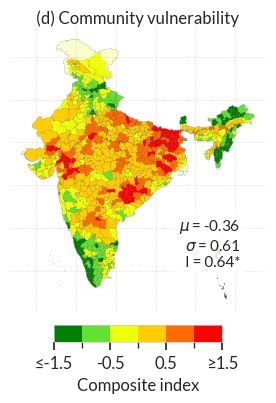

In [23]:
  # You can change 'turbo_r' to any other colormap
total_figs = len(list(indicator_text.keys())[-1:])
ncols = 1
nrows = math.ceil(total_figs / ncols)

fig, axes = plt.subplots(nrows, ncols, figsize=(2.8*ncols, 3.5*nrows), subplot_kw={'projection': ccrs.PlateCarree()})
# axes = axes.flatten()
interval = 1
for index, cluster_type in enumerate(list(indicator_text.keys())[-1:]):
    prefix = chr(ord('`')+index+4)
    dax = axes
    
    # Filter out NaN and Inf values
    column_name = f"CI_{cluster_type}"
    print(column_name)
    valid_data = data_resilience_gdf[np.isfinite(data_resilience_gdf[column_name])]
    
    data_resilience_gdf.plot(column=column_name, cmap=cmap_r.reversed(), 
                    norm=norm, 
                    ax=dax, edgecolor="black",
                    legend=False,
                    legend_kwds={'orientation': "horizontal", "location": "bottom", 
                                 "label": "Composite index"},
                    missing_kwds={'color': 'gainsboro'}, linewidth=0.05)
    boundary.boundary.plot(ax=dax, color='grey', linewidth=0.2, alpha = 0.5)
    boundary_diff.plot(ax=dax, color='white', linewidth=0.1, alpha = 0.8)
    
    # dax.set_title(f"({prefix}) {cluster_type}")
    title = f"({prefix}) {indicator_text[cluster_type]}"
    wrapped_title = "\n".join(textwrap.wrap(title, width=30))
    dax.set_title(wrapped_title, fontsize=12, va ='top', ha='center')
    dax.axis('off')

    gridlines = dax.gridlines(draw_labels=False, crs=ccrs.PlateCarree(), linestyle='dotted', color='black', linewidth=0.5, alpha=0.2)
    axes.axis('off')

    column_values = data_resilience_moran[column_name]
    feature_mean, feature_std, moran_i, moran_p = calculate_statistics(column_values, w_resilience)
    add_annotations(dax, feature_mean, feature_std, moran_i, moran_p)

# Create a new axis for the colorbar
# cbar_ax = fig.add_axes([0.2, -0.0, 0.6, 0.03])  # [left, bot tom, width, height]
cbar_ax = fig.add_axes([0.2, -0.0, 0.6, 0.05])  # [left, bot tom, width, height]

# Create a custom colorbar
sm = plt.cm.ScalarMappable(cmap=cmap_r.reversed(), norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, cax=cbar_ax, orientation='horizontal', )
cbar.outline.set_linewidth(0.5)
cbar.set_ticks(np.arange(lower_bound, upper_bound + interval, interval).tolist())
cbar.set_ticklabels(['≤' + str(lower_bound)] + 
                   [str(i) for i in np.arange(lower_bound + interval, upper_bound, interval).tolist()] + 
                   ['≥' + str(upper_bound)])
cbar.set_label("Composite index", fontsize=12)
cbar.ax.tick_params(labelsize=12)
# plt.subplots_adjust(hspace=0, wspace=0.1)

# Save the plot
plt.tight_layout()
plt.savefig(f"graphics/CommunityIndex.png", dpi=600, bbox_inches='tight')
plt.show()


## Case Study: District Clustering Based on Infrastructure

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Random state: 17
['CI_critical_infrastructure', 'CI_infrastructure_accessibility', 'CI_social_infrastructure'] ['CI_critical_infrastructure', 'CI_infrastructure_accessibility', 'CI_social_infrastructure']


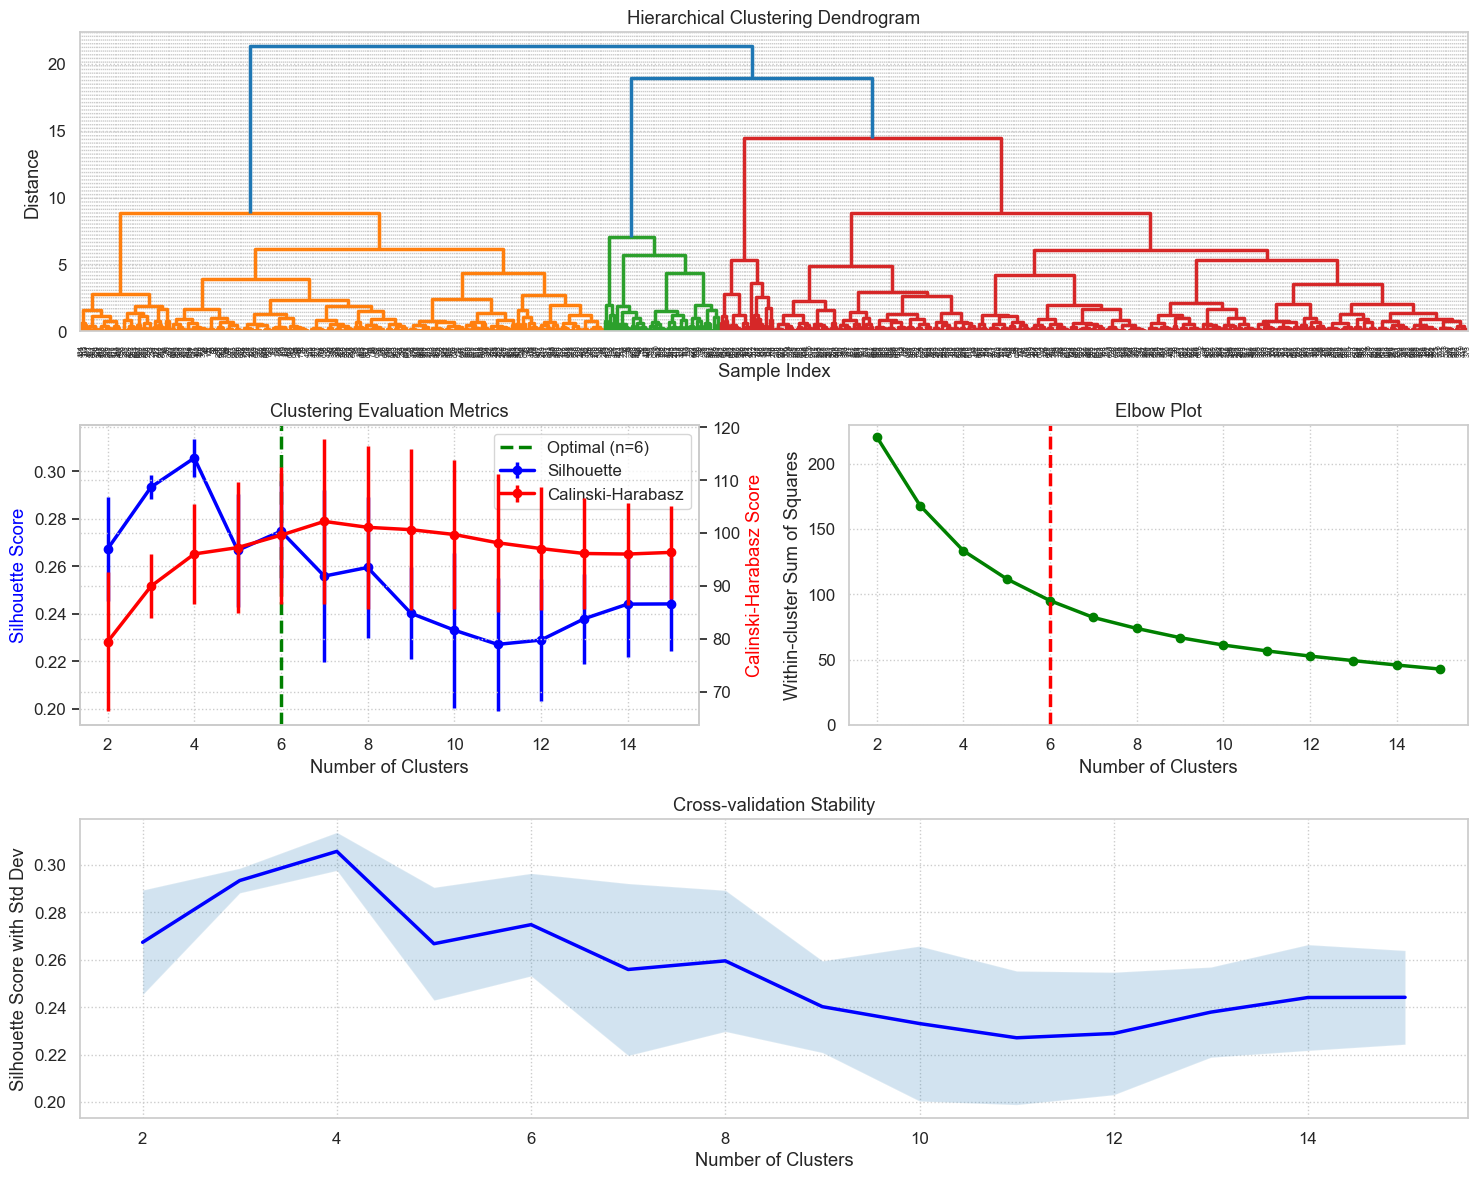

Optimal number of clusters: 6

=== Metrics for 6 clusters (closest match) ===
Number of clusters: 6
Silhouette score: 0.275 ± 0.022
Calinski-Harabasz score: 99.594 ± 12.934
WCSS: 95.124


In [17]:
%load_ext autoreload
%autoreload 2

import random
import seaborn as sns
import numpy as np
import src.pca_clustering as pc

random_state = 17 #random.randint(0, 100) #44 for hierarchical, # 14 for KMeans, 75 for BisectKMean, Gaussina 31, Birch 25
print(f"Random state: {random_state}")

# Set seaborn style
sns.set_style("whitegrid", {'grid.linestyle': 'dotted'})
sns.set_context("notebook", font_scale=1.1, rc={"lines.linewidth": 2.5})


ci_vars = [
    f'CI_{cluster_type}' 
    for cluster_type in indicators_dict.keys() 
    if cluster_type != 'hazard' and cluster_type != 'community'
]
ci_labels = [
    f'CI_{cluster_type}' 
    for cluster_type in indicators_dict.keys() 
    if cluster_type not in {'hazard', 'community'}
]
print(ci_vars, ci_labels)

clustering_method = 'hierachical'
cluster_df = data_resilience_gdf[[cluster_type for cluster_type in ci_vars]].copy()
# coastal_cyclone_gdf.to_parquet("data/coastal_cyclone_data.parquet")

def get_silhouette_score(results, num_clusters=None):
    """
    Prints metrics (Silhouette, Calinski-Harabasz, WCSS) for the best or specified num_clusters.
    """
    results_df = results["results_df"]
    
    if num_clusters:
        # Find the run closest to the desired cluster count
        idx = np.argmin(np.abs(results_df["n_clusters"] - num_clusters))
        print(f"\n=== Metrics for {num_clusters} clusters (closest match) ===")
    else:
        # Default: use the best run (highest silhouette score)
        idx = np.argmax(results_df["silhouette_score"])
        print("\n=== Best Clustering Results ===")
    
    silhouette = results_df["silhouette_score"].iloc[idx]
    silhouette_std = results_df["silhouette_std"].iloc[idx]
    calinski = results_df["calinski_score"].iloc[idx]
    calinski_std = results_df["calinski_std"].iloc[idx]
    wcss = results_df["inertia"].iloc[idx] if "inertia" in results_df.columns else "N/A"
    n_clusters = int(round(results_df["n_clusters"].iloc[idx]))

    print(f"Number of clusters: {n_clusters}")
    print(f"Silhouette score: {silhouette:.3f} ± {silhouette_std:.3f}")
    print(f"Calinski-Harabasz score: {calinski:.3f} ± {calinski_std:.3f}")
    print(f"WCSS: {wcss if isinstance(wcss, str) else f'{wcss:.3f}'}")

def perform_clustering(clustering_method, cluster_df, random_state, num_clusters=None):
    method_mapping = {
        'KMeans': pc.kmeans_clustering_analysis,
        'BisectKMean': pc.bisecting_kmeans_clustering_analysis,
        'hierachical': pc.hierarchical_clustering_analysis,
        'affinity_propagation': pc.affinity_propagation_analysis,
        'GaussianMixture': pc.gaussian_mixture_clustering_analysis,
        'Birch': pc.birch_clustering_analysis
    }
    
    clustering_func = method_mapping.get(clustering_method)
    
    if clustering_method == 'affinity_propagation':
        # Run AP clustering analysis
        results = clustering_func(
            cluster_df, 
            n_splits=3, 
            random_state=random_state,
            normalize=False
        )
        
        # Get labels and exemplars (AP doesn't return centroids directly)
        labels = results['labels']
        exemplars = results['final_model'].cluster_centers_indices_
        
        # Compute centroids (mean of points in each cluster)
        centroids = pd.DataFrame(
            np.vstack([cluster_df[labels == i].mean(axis=0) 
                      for i in np.unique(labels)]),
            columns=cluster_df.columns
        )
    else:
        # For other clustering methods (K-Means, Hierarchical, etc.)
        results = clustering_func(
            cluster_df, 
            n_splits=3, 
            random_state=random_state, 
            num_clusters=num_clusters, 
            normalize=False
        )
        labels = results['labels']
        centroids = results['centroids']

    num_clusters = len(np.unique(labels))
    print(f"Optimal number of clusters: {results.get('optimal_clusters', num_clusters)}")
    get_silhouette_score(results, num_clusters=num_clusters)

    return labels, centroids, num_clusters

labels, centroids, num_clusters = perform_clustering(
    clustering_method, 
    cluster_df, 
    random_state, 
    num_clusters=6  # Let AP determine clusters automatically
)

data_resilience_gdf['cluster'] = labels
for cluster_type in ci_vars:
    data_resilience_gdf[f'CI_{cluster_type}_centroid'] = data_resilience_gdf['cluster'].map(
        centroids[cluster_type].to_dict()
    ).values

['CI_critical_infrastructure', 'CI_infrastructure_accessibility', 'CI_social_infrastructure'] ['CI_critical_infrastructure', 'CI_infrastructure_accessibility', 'CI_social_infrastructure']


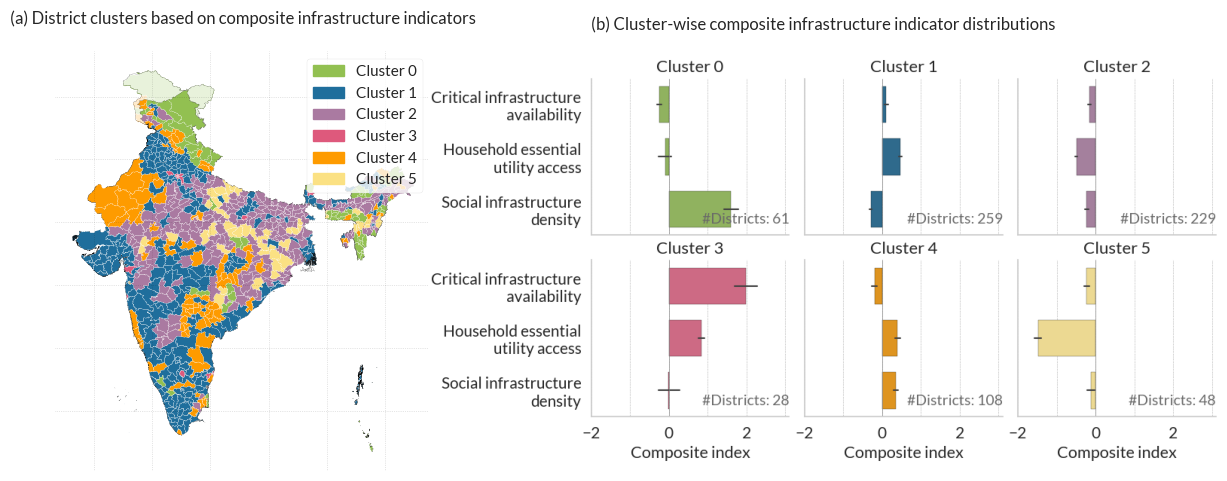

In [18]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
import numpy as np
import matplotlib.gridspec as gridspec
from matplotlib.ticker import AutoMinorLocator
from cartopy import crs as ccrs
import pypalettes

indicators_key_dict = cf.indicators_key_dict
ci_columns = [
    f'CI_{cluster_type}' 
    for cluster_type in indicators_dict.keys() 
    if cluster_type != 'hazard' and cluster_type != 'community'
]
ci_column_titles = [indicators_key_dict[cluster_type] for cluster_type in indicators_dict.keys() 
    if cluster_type != 'hazard' and cluster_type != 'community']
print(ci_vars, ci_labels)

sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1.3)
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Lato']

# this_cmap = pypalettes.load_cmap("Peru1")  # Load a custom colormap
this_cmap = mcolors.ListedColormap(pypalettes.load_cmap("Signac").colors)

fig = plt.figure(figsize=(15, 6.5))  # Adjust overall figure size as needed
gs = gridspec.GridSpec(1, 2, width_ratios=[0.95, 2], figure=fig, wspace=-0.005)  # First plot takes up 1/3 of width, second plot 2/3
ax_map = fig.add_subplot(gs[0], projection=ccrs.PlateCarree())  # The first subplot will occupy the left panel
ax_map.set_title('(a) District clusters based on composite infrastructure indicators', fontsize=12, pad=20)

colors = this_cmap(np.linspace(0, 1, num_clusters))
new_cmap = LinearSegmentedColormap.from_list("new", colors, N=num_clusters).reversed()

data_resilience_gdf.plot(
    ax=ax_map,
    column='cluster',
    cmap=new_cmap,
    edgecolor=None,
    legend=False,  # Turn off the default legend
    missing_kwds={'color': 'lightgrey'},
    linewidth=0.1,
    alpha=1
)
boundary_diff.plot(ax=ax_map, color='white', edgecolor = 'black', linewidth=0.2, linestyle = '--', alpha = 0.8)

legend_handles = []
for cluster_value in sorted(data_resilience_gdf['cluster'].unique()):  # Sorting cluster values
    legend_handles.append(mpatches.Patch(color=new_cmap(cluster_value), label=f'Cluster {cluster_value}'))

# Add the custom legend
legend = ax_map.legend(handles=legend_handles, title=None, loc='best', fontsize = 11, title_fontsize = 13, ncol = 1)
legend.get_frame().set_facecolor((1, 1, 1, 0.1))   # Set the frame's edge color to white
legend.get_frame().set_linewidth(0.2)
ax_map.axis('off')
#label size
plt.rcParams.update({'font.size': 8})
#hide the axis labels
ax_map.set_xticks([])
ax_map.set_yticks([])

# ctx.add_basemap(ax_map, crs=coastal_cyclone_gdf.crs, source=ctx.providers.CartoDB.Voyager, zoom=5)

gridlines = ax_map.gridlines(draw_labels=False, crs=ccrs.PlateCarree(), linestyle='dotted', color='black', linewidth=0.5, alpha=0.2)
data_melted = data_resilience_gdf.melt(
    id_vars=["cluster"], 
    value_vars=ci_columns, 
    var_name="CI_Variable", 
    value_name="Value"
)


ci_label_mapping = dict(zip(ci_columns, ci_column_titles))
data_melted["CI_Variable"] = data_melted["CI_Variable"].map(ci_label_mapping)

data_melted["cluster"] = data_melted["cluster"].astype(int)
unique_clusters = sorted(data_melted["cluster"].unique())
ncols = 3
num_rows = (len(unique_clusters)) // ncols  # Rows for grid layout

inner_fig, inner_axes = plt.subplots(
    num_rows, ncols, figsize=(3.5 * ncols, 2.7 * num_rows), constrained_layout=True, sharex=True, sharey=True, 
)
inner_axes = inner_axes.flatten()

for idx, cluster in enumerate(unique_clusters):
    cluster_data = data_melted[data_melted["cluster"] == cluster]
    
    sns.barplot(
        data=cluster_data,
        x="Value",
        y="CI_Variable",
        errorbar=("ci", 95),  # Confidence interval
        palette=[new_cmap(unique_clusters.index(cluster) / (num_clusters - 1))],
        hue ="CI_Variable",
        orient="h", alpha=1,
        linewidth=0.2,
        width=0.7,
        edgecolor='black',
        # errwidth=1.5,
        ax=inner_axes[idx],
        err_kws={'linewidth': 1.5},
        legend = False
    )
    
    count = data_resilience_gdf[data_resilience_gdf['cluster'] == cluster].shape[0]
    inner_axes[idx].annotate(f"#Districts: {count}", 
                  xy=(1, 0.175),          # anchor point at top right
                  xytext=(0, -5),  # offset text slightly from corner
                  xycoords='axes fraction',
                  textcoords='offset points',
                  ha='right',         # horizontal alignment
                  va='top',          # vertical alignment
                  fontsize=14, color = 'dimgrey')
    # Add a line at 0
    inner_axes[idx].axvline(0, color='grey', linewidth=0.5)
    inner_axes[idx].set_xlim(-2, 3.1)
    inner_axes[idx].set_xticks(np.arange(-2,3, 2))

    inner_axes[idx].tick_params(axis='both', which='major', labelsize=16)  # Major tick labels
    inner_axes[idx].tick_params(axis='both', which='minor', length=1, color='grey', labelsize=12)  # Minor ticks
    inner_axes[idx].xaxis.set_minor_locator(AutoMinorLocator(2))  # Adds 2 minor ticks between major ticks
    
    # Customize the plot
    inner_axes[idx].set_title(f"Cluster {cluster}", fontsize=16)
    inner_axes[idx].set_xlabel("Composite index")
    inner_axes[idx].set_ylabel("")
    inner_axes[idx].tick_params(axis='both', which='major', labelsize=15)
    inner_axes[idx].spines['top'].set_visible(False)
    inner_axes[idx].spines['right'].set_visible(False)
    inner_axes[idx].patch.set_alpha(0.7)
    inner_axes[idx].grid(axis='x', which='major', linestyle=':', linewidth=0.5, alpha=1, color='grey')  # Major grid
    inner_axes[idx].grid(axis='x', which='minor', linestyle=':', linewidth=0.5, alpha=1, color='grey')  # Minor grid

for idx in range(len(unique_clusters), len(inner_axes)):
    inner_fig.delaxes(inner_axes[idx])
    

ax_bars = fig.add_subplot(gs[1:])  # The right panel will hold the inner plot
ax_bars.set_title('(b) Cluster-wise composite infrastructure indicator distributions', fontsize=12, pad=20)
ax_bars.axis("off")  # Turn off axes for the embedding
inner_fig.canvas.draw()  # Render the inner figure
inner_image = np.array(inner_fig.canvas.renderer.buffer_rgba())  # Get the rendered image
ax_bars.imshow(inner_image)  # Display the image in the right panel
# plt.subplots_adjust(top=1)

plt.close(inner_fig)
plt.tight_layout()

plt.savefig("graphics/combined_cluster_plots.png", dpi=600, bbox_inches='tight')
plt.show()


In [15]:
# data_resilience_gdf[['district','state','distid','geometry',
#     'CI_hazard','CI_critical_infrastructure','CI_social_infrastructure',
#     'CI_community','CI_infrastructure_accessibility','CI_state_capacity']].to_parquet("data/composite_resilience_indices.parquet")

In [24]:
data_gdf.columns

Index(['district', 'state', 'stateid', 'distid', 'geometry',
       'highway_per_100sqkm', 'roads_100sqkm', 'transmission_100sqkm',
       'perc_extraction', 'perc_hh_electricity', 'perc_hh_sanitation',
       'perc_hh_drinkingwater', 'perc_hh_cleanfuel', 'police_density',
       'schools_density', 'pri_health_density', 'sec_health_density',
       'per_capita_income', 'perc_women_literate', 'perc_child_uweight',
       'perc_women_uweight', 'perc_women_aneamic', 'severe_cyclones',
       'wind_speed_knots', 'pmss_m', 'pmp_cm', 'koppen_zon'],
      dtype='object')